## Setup

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

The data: Protein quantity measurements of brain tissue samples from multiple regions.

Here we read in the data, store a feature for visualization later, and drop non-numeric features from the dataset.

In [56]:
data = pd.read_csv('ProteinAndPathologyQuantifications.csv')
structures = data['structure_acronym']
structures

0      FWM
1      PCx
2      FWM
3      FWM
4      TCx
      ... 
372    PCx
373    HIP
374    HIP
375    PCx
376    TCx
Name: structure_acronym, Length: 377, dtype: object

What do these acronyms mean? Each corresponds to a brain region. In this dataset, the four brain regions are:

* **[Temporal Cortex](https://en.wikipedia.org/wiki/Temporal_lobe) (TCx)**: processing audio data, processing visual data, encoding long-term memories.
* **[Parietal Cortex](https://en.wikipedia.org/wiki/Parietal_lobe) (PCx)**: processing sense of touch, temperature, and pain; processing spatial and navigation information. 
* **[Forebrain White Matter](https://medlineplus.gov/ency/article/002344.htm) (FWM)**: contains the nerve fibers and the myelin sheath, used to quickly and reliably transmit electrical impulses to the body.
* **[Hippocampus](https://en.wikipedia.org/wiki/Hippocampus) (HIP)**: part of the temporal lobe, has a crucial role in learning and memory.


In [57]:
clean_data = data.drop(columns=['donor_id', 'donor_name', 'structure_id', 'structure_acronym'])
print(clean_data.shape)
clean_data

(377, 29)


,ihc_a_syn,ihc_tau2_ffpe,ihc_at8_ffpe,ihc_at8,ihc_ptdp_43_ffpe,ihc_a_beta_ffpe,ihc_a_beta,ihc_iba1_ffpe,ihc_gfap_ffpe,ptau_ng_per_mg,...,il_4_pg_per_mg,rantes_pg_per_mg,ab40_pg_per_mg,a_syn_pg_per_mg,ifn_g_pg_per_mg,mcp_1_pg_per_mg,bdnf_pg_per_mg,mip_1a_pg_per_mg,il_7_pg_per_mg,ab42_pg_per_mg
0,0.000078,0.002358,0.001137,0.000110,0.001259,0.008335,0.004596,0.029660,0.047025,0.528121,...,2.68,15.99,0.736100,0.122288,1.47,20.78,5.03736,9.38,11.78,523.292251
1,0.000063,0.002762,0.001272,0.000164,0.002354,0.005047,0.008108,0.051882,0.057511,0.295942,...,3.02,24.04,0.669094,0.111962,1.44,40.40,4.95462,8.10,45.02,81.493875
2,0.000064,0.003468,0.013787,0.016023,0.001708,0.007365,0.017214,0.057172,0.033150,1.543643,...,0.80,129.80,0.736100,0.091084,0.54,46.88,5.88409,27.00,15.82,470.734514
3,0.000049,0.003035,0.001707,0.000137,0.001729,0.004046,0.003868,0.049068,0.043767,1.078323,...,1.30,15.16,8.995575,0.054076,0.76,10.34,16.13524,8.06,24.22,568.368571
4,0.000080,0.002088,0.004489,0.000062,0.001513,0.015809,0.046244,0.045467,0.023337,1.688704,...,0.00,17.90,95.931000,0.030000,1.22,21.38,0.03000,10.52,23.72,438.863263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,0.000046,0.001989,0.000533,0.000082,0.001130,0.003128,0.000967,0.052738,0.038984,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,0.000089,0.001918,0.004685,0.000923,0.001181,0.003483,0.010057,0.086936,0.054531,1.519767,...,0.00,5.94,0.574500,0.248816,0.00,7.16,2.94819,17.82,1.38,0.054413
374,0.000066,0.002275,0.006337,0.009560,0.001395,0.001710,0.006445,0.066469,0.044727,2.751660,...,0.00,7.62,0.900050,0.183510,0.00,3.14,10.56419,21.96,0.60,0.181375
375,0.000793,0.004384,0.001266,0.000093,0.002505,0.009795,0.020585,0.033144,0.058040,0.708701,...,0.02,4.88,0.444250,0.045202,0.00,7.20,2.83064,0.00,12.46,205.886650


The other columns indicate the amount of a protein present in that brain tissue sample.

## Pre-processing

Some of these cells have missing data, represented by NaN (not-a-number) values. Because PCA can't handle missing data, we want to replace all NaN values with a reasonable alternative for this domain, using [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). Let's replace missing values with the **mean** of the exisitng values in that column.

In [58]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
clean_data = imp_mean.fit_transform(clean_data)

Next, let's normalize the data using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

This is important because PCA picks the dimensions (linear combinations of the features) that **maximize variance**. We want this procedure to be agnostic to the units of the dataset. For example, let's say one column had units `km` and you then change it to `cm`. The variance of that column will now jump up 100x, and therefore PCA will put more weight on that column. This is undesirable because nothing has fundamentally changed amongst the dataset. To avoid this behavior, we normalize the data before inputting it into PCA.

In [59]:
clean_data = StandardScaler().fit_transform(clean_data)
clean_data

array([[-0.18960178, -0.47869734, -0.82037204, ..., -0.24277687,
        -0.24779252,  1.26252476],
       [-0.20076815, -0.38541831, -0.80927418, ..., -0.26203924,
         2.60171979, -0.8461383 ],
       [-0.19978468, -0.22244926,  0.22159515, ...,  0.02238156,
         0.09853809,  1.01167151],
       ...,
       [-0.19812106, -0.49777969, -0.39204777, ..., -0.05346398,
        -1.2062025 , -1.23423539],
       [ 0.33793089, -0.01119573, -0.80977155, ..., -0.38393386,
        -0.18949925, -0.25242301],
       [-0.18862476, -0.53009655, -0.8027862 , ..., -0.25120416,
        -0.44324644, -1.23329665]])

##  PCA

Finally, we set-up our [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) model, fit it, and transform the data (embed it in low dimensional space)

In [60]:
pca = PCA(n_components=clean_data.shape[1])
pca.fit(clean_data)
transformed = pca.transform(clean_data)

We can see how much variance each PC explains. Select the first 5 components.

In [61]:
# Display the explained variance ratio of the first 5 PCs
print(pca.explained_variance_ratio_[0:5])
# What is the total ratio of the variance this explains?
print(pca.explained_variance_ratio_[0:5].sum())

[0.19729818 0.11293478 0.06357026 0.06211117 0.05287326]
0.48878766190718437


**Question**: What ratio of the total variance would be explained by the first 29 components?

In [62]:
print(pca.explained_variance_ratio_[0:29].sum())

1.0


## Plots

Here we see that two main clusters are apparent in this low dimensional space

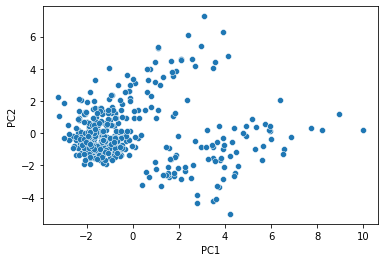

In [63]:
sns.scatterplot(x=transformed[:,0], y=transformed[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

**Question**: Did we just do clustering using PCA? Why or why not?

After coloring by brain region, we can see that the islands represent the difference between the hippocampus and other brain regions

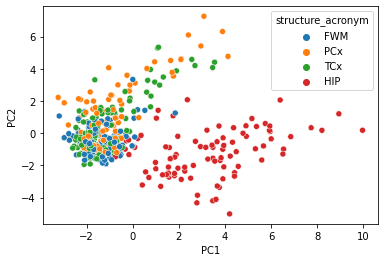

In [64]:
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=structures)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

**Question**: How can we interpret this result, in light of what our dataset represents?

We can look at other PCs as well. There are outliers that become apparent here!

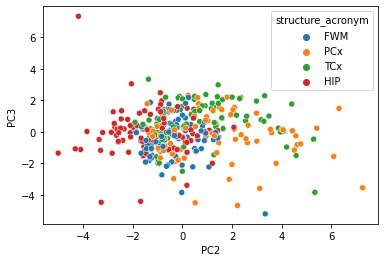

In [65]:
sns.scatterplot(x=transformed[:,1], y=transformed[:,2], hue=structures)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.show()

**Question**: Why was PCA helpful for this problem (why did we use it)?